--Analisis dataset--

In [1]:
!pip install -U datasets pandas matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.9 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/8.1 MB 1.6 MB/s eta 0:00:05
   ----- ---------------------------------- 1.0/8.1 MB 1.5 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/8.1 MB 1.9 MB/s eta 0:00:04
   ---------- ----------------------------- 2.1/8.1 MB 1.9 MB/s eta 0:00:04
   ----------- ---------------------------- 2.4/8.1 MB 1.8 MB/s eta 0:00:04
   -------------- ------------------------- 2.9/8.1 MB 1.8 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/8.1 MB 1.8 MB/s eta 0:00:03
   ------------------ --------------------- 3.7/8.1 MB 1.8 MB/s eta 0:00:03
   --------------------- ------------------ 4.5/8.1 MB 2.0 MB/s eta 0:00:02
   ------------------------- -------------- 5.2/8.1 MB 2.2 MB/s eta 0:00:02
   -----------------------

In [1]:
import os
import math
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from datasets import load_dataset

SAMPLE_N = None  
RANDOM_SEED = 42

print("✅ Imports listos")

✅ Imports listos


In [3]:
if SAMPLE_N:
    squad = load_dataset("squad", split=f"validation[:{SAMPLE_N}]")
else:
    squad = load_dataset("squad", split="validation")

print("Total ejemplos cargados:", len(squad))
squad_df = squad.to_pandas()
squad_df.head(3)

Total ejemplos cargados: 10570


,id,title,context,question,answers
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
1,56be4db0acb8001400a502ed,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"{'text': ['Carolina Panthers', 'Carolina Panth..."
2,56be4db0acb8001400a502ee,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"{'text': ['Santa Clara, California', 'Levi's S..."


In [5]:
print("Columnas:", squad_df.columns.tolist())
print("\nTipos de datos:")
print(squad_df.dtypes)
print("\nConteo de nulos por columna:")
print(squad_df.isnull().sum())

Columnas: ['id', 'title', 'context', 'question', 'answers']

Tipos de datos:
id          object
title       object
context     object
question    object
answers     object
dtype: object

Conteo de nulos por columna:
id          0
title       0
context     0
question    0
answers     0
dtype: int64


In [7]:
def get_first_answer_text(answers):
    if not answers:
        return ""
    texts = answers.get("text", [])
    return texts[0] if len(texts)>0 else ""

def get_first_answer_start(answers):
    if not answers:
        return -1
    starts = answers.get("answer_start", [])
    return starts[0] if len(starts)>0 else -1

df = squad_df.copy()
df["answer_text"] = df["answers"].apply(get_first_answer_text)
df["answer_start"] = df["answers"].apply(get_first_answer_start)
df = df[["id","title","context","question","answer_text","answer_start"]]
df.head(3)

,id,title,context,question,answer_text,answer_start
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,Denver Broncos,177
1,56be4db0acb8001400a502ed,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,249
2,56be4db0acb8001400a502ee,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"Santa Clara, California",403


In [9]:
df["len_context"] = df["context"].apply(len)
df["len_question"] = df["question"].apply(len)
df["len_answer"] = df["answer_text"].apply(len)
stats = df[["len_context","len_question","len_answer"]].describe().T
stats["median"] = df[["len_context","len_question","len_answer"]].median().values
stats = stats[["count","mean","median","std","min","25%","50%","75%","max"]]
display(stats)

,count,mean,median,std,min,25%,50%,75%,max
len_context,10570.0,778.983349,703.0,350.701553,157.0,574.0,703.0,914.0,4063.0
len_question,10570.0,60.013718,57.0,21.152822,12.0,45.0,57.0,72.0,197.0
len_answer,10570.0,19.382971,14.0,19.262084,1.0,8.0,14.0,23.0,160.0


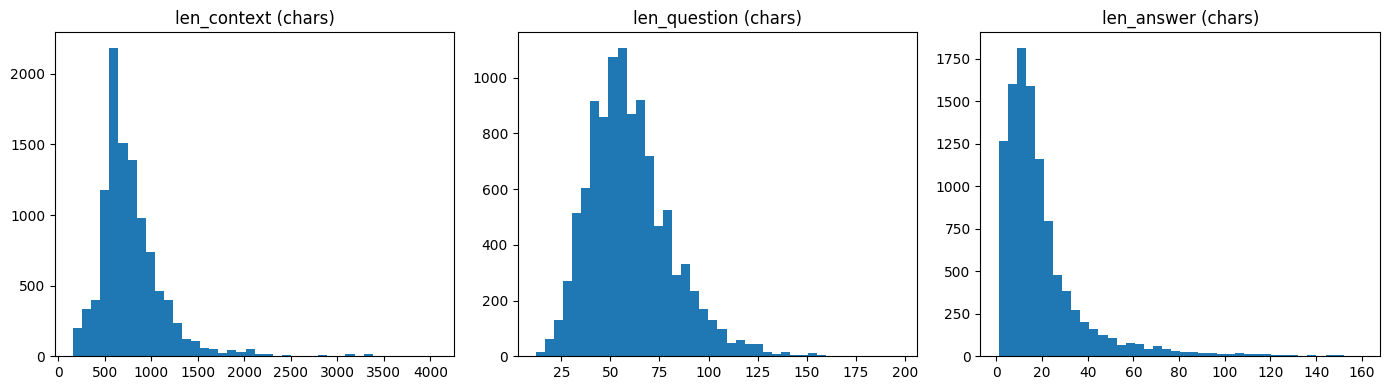

In [11]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.hist(df["len_context"], bins=40)
plt.title("len_context (chars)")
plt.subplot(1,3,2)
plt.hist(df["len_question"], bins=40)
plt.title("len_question (chars)")
plt.subplot(1,3,3)
plt.hist(df["len_answer"], bins=40)
plt.title("len_answer (chars)")
plt.tight_layout()
plt.show()

In [13]:
title_counts = df["title"].value_counts().rename_axis("title").reset_index(name="counts")
print("Artículos distintos:", title_counts.shape[0])
display(title_counts.head(10))

Artículos distintos: 48


,title,counts
0,Super_Bowl_50,810
1,Nikola_Tesla,511
2,Martin_Luther,479
3,American_Broadcasting_Company,407
4,Doctor_Who,319
5,Economic_inequality,297
6,Victoria_and_Albert_Museum,295
7,Chloroplast,295
8,Rhine,291
9,Teacher,268


In [15]:
import re
def simple_tokens(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9áéíóúüñ]+", " ", text)  # permite español básico
    return [t for t in text.split() if t]

all_question_tokens = Counter()
for q in df["question"].astype(str):
    all_question_tokens.update(simple_tokens(q))

print("Top 30 tokens en preguntas:")
print(all_question_tokens.most_common(30))

Top 30 tokens en preguntas:
[('the', 8317), ('what', 6087), ('of', 4015), ('in', 3025), ('to', 2424), ('is', 2083), ('did', 2037), ('was', 1978), ('a', 1539), ('who', 1332), ('how', 1242), ('s', 1182), ('for', 1021), ('when', 864), ('and', 843), ('which', 749), ('are', 738), ('many', 701), ('that', 651), ('on', 614), ('does', 595), ('where', 505), ('by', 497), ('do', 467), ('with', 466), ('were', 451), ('as', 442), ('have', 436), ('from', 415), ('be', 403)]


In [17]:
def check_answer_in_context(row):
    ans = row["answer_text"]
    start = row["answer_start"]
    ctx = row["context"]
    if ans == "":
        return False, "no_answer_text"
    if ans in ctx:
        if start >= 0:
            if ctx[start:start+len(ans)] == ans:
                return True, "ok"
            else:
                return False, "start_mismatch"
        else:
            return True, "found_no_start"
    else:
        return False, "not_found"

checks = df.apply(lambda r: check_answer_in_context(r), axis=1)
df["answer_in_context"] = [c[0] for c in checks]
df["answer_check_reason"] = [c[1] for c in checks]

counts_checks = df["answer_check_reason"].value_counts()
print("Resumen de verificación answer/context:")
display(counts_checks)
df[df["answer_check_reason"]!="ok"].head(10)

Resumen de verificación answer/context:


answer_check_reason
ok    10570
Name: count, dtype: int64

,id,title,context,question,answer_text,answer_start,len_context,len_question,len_answer,answer_in_context,answer_check_reason


In [19]:
dups_q = df["question"].duplicated().sum()
dups_pair = df.duplicated(subset=["context","question"]).sum()
print("Preguntas repetidas (solo pregunta):", dups_q)
print("Pares (context,question) duplicados:", dups_pair)
df[df["question"].duplicated(keep=False)].sort_values("question").head(10)

Preguntas repetidas (solo pregunta): 31
Pares (context,question) duplicados: 29


,id,title,context,question,answer_text,answer_start,len_context,len_question,len_answer,answer_in_context,answer_check_reason
4825,5726356938643c19005ad300,Packet_switching,Packet mode communication may be implemented w...,How are packets normally forwarded,by intermediate network nodes asynchronously u...,152,564,34,159,True,ok
4822,5726219489a1e219009ac2cf,Packet_switching,Packet mode communication may be implemented w...,How are packets normally forwarded,"asynchronously using first-in, first-out buffe...",182,564,34,129,True,ok
4821,5726219489a1e219009ac2ce,Packet_switching,Packet mode communication may be implemented w...,How is packet mode communication implemented,with or without intermediate forwarding nodes,45,564,45,45,True,ok
4824,5726356938643c19005ad2ff,Packet_switching,Packet mode communication may be implemented w...,How is packet mode communication implemented,with or without intermediate forwarding nodes,45,564,45,45,True,ok
10514,5737958b1c456719005744c6,Force,It is a common misconception to ascribe the st...,How is the Pauli exclusion priciple manifested...,as a structural force,657,766,66,21,True,ok
10510,5737958ac3c5551400e51f2c,Force,It is a common misconception to ascribe the st...,How is the Pauli exclusion priciple manifested...,as a structural force,657,766,66,21,True,ok
340,56bf3a223aeaaa14008c9577,Super_Bowl_50,Carolina suffered a major setback when Thomas ...,How many years has Thomas Davis played in the ...,11,56,306,50,2,True,ok
337,56beb7fd3aeaaa14008c92b8,Super_Bowl_50,Carolina suffered a major setback when Thomas ...,How many years has Thomas Davis played in the ...,11,56,306,50,2,True,ok
158,56be5523acb8001400a5032f,Super_Bowl_50,"On May 21, 2013, NFL owners at their spring me...",How much did it cost to build Levi's Stadium?,$1.2 billion,113,326,45,12,True,ok
162,56beb2153aeaaa14008c9227,Super_Bowl_50,"On May 21, 2013, NFL owners at their spring me...",How much did it cost to build Levi's Stadium?,$1.2 billion,113,326,45,12,True,ok


count    10570.000000
mean         3.139546
std          3.048713
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         30.000000
Name: answer_tokens_est, dtype: float64


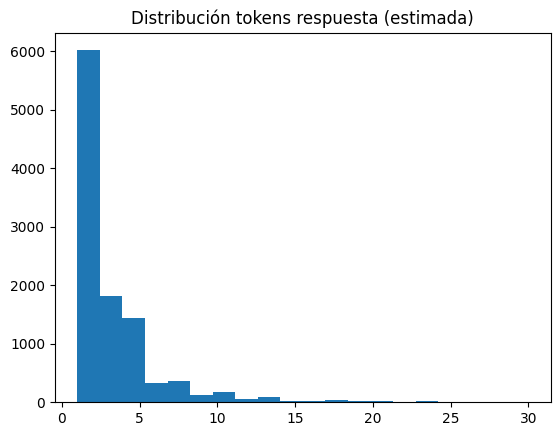

In [21]:
df["answer_tokens_est"] = df["answer_text"].astype(str).apply(lambda x: len(simple_tokens(x)))
print(df["answer_tokens_est"].describe())
plt.hist(df["answer_tokens_est"], bins=20)
plt.title("Distribución tokens respuesta (estimada)")
plt.show()

In [23]:
os.makedirs("analysis_outputs", exist_ok=True)
df.to_csv("analysis_outputs/squad_inspected.csv", index=False)
problematic = df[df["answer_check_reason"]!="ok"]
problematic.to_csv("analysis_outputs/squad_problematic_examples.csv", index=False)
print("Guardado: analysis_outputs/squad_inspected.csv")
print("Guardado: analysis_outputs/squad_problematic_examples.csv (ejemplos problemáticos)")

Guardado: analysis_outputs/squad_inspected.csv
Guardado: analysis_outputs/squad_problematic_examples.csv (ejemplos problemáticos)


In [25]:
N = len(df)
n_missing_answer = (df["answer_text"]=="").sum()
n_not_found = (df["answer_check_reason"]=="not_found").sum()
n_start_mismatch = (df["answer_check_reason"]=="start_mismatch").sum()

print("Resumen SQuAD (validación)")
print("--------------------------")
print(f"Total ejemplos: {N}")
print(f"Respuestas vacías: {n_missing_answer}")
print(f"Respuestas no encontradas en context: {n_not_found}")
print(f"Respuestas con start mismatch: {n_start_mismatch}")
print(f"Artículos distintos: {df['title'].nunique()}")
print("\nMedias longitudes (context, question, answer chars):")
print(df[["len_context","len_question","len_answer"]].mean().to_dict())

Resumen SQuAD (validación)
--------------------------
Total ejemplos: 10570
Respuestas vacías: 0
Respuestas no encontradas en context: 0
Respuestas con start mismatch: 0
Artículos distintos: 48

Medias longitudes (context, question, answer chars):
{'len_context': 778.9833491012299, 'len_question': 60.01371807000946, 'len_answer': 19.382970671712393}


In [27]:
print("Dimensiones (filas, columnas):", squad_df.shape)

print("Número total de características:", squad_df.shape[1])

print("\n=== Info del DataFrame ===")
print(squad_df.info())

print("\n=== Descripción columnas numéricas ===")
display(squad_df.describe())

print("\n=== Descripción columnas tipo object ===")
display(squad_df.describe(include=["object"]))

Dimensiones (filas, columnas): (10570, 5)
Número total de características: 5

=== Info del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10570 non-null  object
 1   title     10570 non-null  object
 2   context   10570 non-null  object
 3   question  10570 non-null  object
 4   answers   10570 non-null  object
dtypes: object(5)
memory usage: 413.0+ KB
None

=== Descripción columnas numéricas ===


,id,title,context,question,answers
count,10570,10570,10570,10570,10570
unique,10570,48,2067,10539,10570
top,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,How is the Pauli exclusion priciple manifested...,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
freq,1,810,30,2,1



=== Descripción columnas tipo object ===


,id,title,context,question,answers
count,10570,10570,10570,10570,10570
unique,10570,48,2067,10539,10570
top,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,How is the Pauli exclusion priciple manifested...,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
freq,1,810,30,2,1


--DeepEval--

In [31]:
!pip install deepeval datasets

In [1]:
from datasets import load_dataset
import pandas as pd
from deepeval.metrics import FaithfulnessMetric, AnswerRelevancyMetric, ContextualPrecisionMetric, ContextualRelevancyMetric, ToxicityMetric
from deepeval.test_case import LLMTestCase

In [3]:
squad = load_dataset("squad", split="validation[:5]")
squad_df = squad.to_pandas()
squad_df.head(3)

,id,title,context,question,answers
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
1,56be4db0acb8001400a502ed,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"{'text': ['Carolina Panthers', 'Carolina Panth..."
2,56be4db0acb8001400a502ee,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"{'text': ['Santa Clara, California', 'Levi's S..."


In [5]:
def get_first_answer(answers):
    texts = answers["text"]

    if not isinstance(texts, (list, tuple)):
        texts = texts.tolist()

    return texts[0] if len(texts) > 0 else ""

def get_first_answer_start(answers):
    starts = answers["answer_start"]

    if not isinstance(starts, (list, tuple)):
        starts = starts.tolist()

    return starts[0] if len(starts) > 0 else -1

eval_data = []
for i, row in squad_df.iterrows():
    eval_data.append({
        "query": row["question"],
        "context": row["context"],
        "expected_answer": get_first_answer(row["answers"]),
        "expected_answer_start": get_first_answer_start(row["answers"])
    })

print("✅ Total ejemplos en eval_data:", len(eval_data))
print("👉 Primer ejemplo:\n", eval_data[0])

✅ Total ejemplos en eval_data: 5
👉 Primer ejemplo:
 {'query': 'Which NFL team represented the AFC at Super Bowl 50?', 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.', 'expected_answer': 'Denver Broncos', 'expected_answer_start': 177}


In [7]:
for item in eval_data:
    if "capital" in item["query"].lower():
        item["model_answer"] = "París"
    else:
        item["model_answer"] = "Respuesta simulada"

print("👉 Primer ejemplo con model_answer:\n", eval_data[0])

👉 Primer ejemplo con model_answer:
 {'query': 'Which NFL team represented the AFC at Super Bowl 50?', 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.', 'expected_answer': 'Denver Broncos', 'expected_answer_start': 177, 'model_answer': 'Respuesta simulada'}


In [9]:
from deepeval.metrics import (
    FaithfulnessMetric,
    AnswerRelevancyMetric,
    ContextualPrecisionMetric,
    ContextualRelevancyMetric,
    ToxicityMetric
)

faithfulness = FaithfulnessMetric()
answer_relevancy = AnswerRelevancyMetric()
contextual_precision = ContextualPrecisionMetric()
contextual_relevancy = ContextualRelevancyMetric()
toxicity = ToxicityMetric()

In [11]:
from deepeval.test_case import LLMTestCase

results = []

for item in eval_data:
    test_case = LLMTestCase(
        input=item["query"],
        actual_output=item["model_answer"],
        expected_output=item["expected_answer"],
        context=[item["context"]],
        retrieval_context=[item["context"]]   # 👈 requerido para Faithfulness
    )

    res = {
        "question": item["query"],
        "expected": item["expected_answer"],
        "answer": item["model_answer"],
        "faithfulness": faithfulness.measure(test_case),
        "answer_relevancy": answer_relevancy.measure(test_case),
        "contextual_precision": contextual_precision.measure(test_case),
        "contextual_relevancy": contextual_relevancy.measure(test_case),
        "toxicity": toxicity.measure(test_case)
    }

    results.append(res)

results_df = pd.DataFrame(results)
results_df.head(10)
results_df.head(10)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

,question,expected,answer,faithfulness,answer_relevancy,contextual_precision,contextual_relevancy,toxicity
0,Which NFL team represented the AFC at Super Bo...,Denver Broncos,Respuesta simulada,0.333333,1.0,1.000000,1.000000,0.0
1,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,Respuesta simulada,0.500000,1.0,1.000000,1.000000,0.0
2,Where did Super Bowl 50 take place?,"Santa Clara, California",Respuesta simulada,0.500000,1.0,1.000000,0.833333,0.0
3,Which NFL team won Super Bowl 50?,Denver Broncos,Respuesta simulada,0.500000,1.0,0.926667,0.800000,0.0
4,What color was used to emphasize the 50th anni...,gold,Respuesta simulada,0.500000,1.0,1.000000,0.500000,0.0


In [11]:
from langchain_ollama import ChatOllama

ollama_llm = ChatOllama(model="mistral", temperature=0.1)

In [13]:
eval_data = []

for i, row in squad_df.head(5).iterrows():
    pregunta = row["question"]
    contexto = row["context"]

    prompt = f"Contexto: {contexto}\n\nPregunta: {pregunta}\n\nRespuesta breve:"

    try:
        respuesta = ollama_llm.invoke(prompt).content
    except Exception as e:
        respuesta = f"Error al generar respuesta: {e}"

    eval_data.append({
        "query": pregunta,
        "context": contexto,
        "expected_answer": get_first_answer(row["answers"]),
        "expected_answer_start": get_first_answer_start(row["answers"]),
        "model_answer": respuesta
    })

print("✅ Ejemplos con respuestas reales generadas")
print(eval_data[0])

✅ Ejemplos con respuestas reales generadas
{'query': 'Which NFL team represented the AFC at Super Bowl 50?', 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.', 'expected_answer': 'Denver Broncos', 'expected_answer_start': 177, 'model_answer': ' Denver Broncos'

In [15]:
from deepeval.test_case import LLMTestCase

results = []

for item in eval_data:
    test_case = LLMTestCase(
        input=item["query"],
        actual_output=item["model_answer"],
        expected_output=item["expected_answer"],
        context=[item["context"]],
        retrieval_context=[item["context"]]
    )

    res = {
        "question": item["query"],
        "expected": item["expected_answer"],
        "answer": item["model_answer"],
        "faithfulness": faithfulness.measure(test_case),
        "answer_relevancy": answer_relevancy.measure(test_case),
        "contextual_precision": contextual_precision.measure(test_case),
        "contextual_relevancy": contextual_relevancy.measure(test_case),
        "toxicity": toxicity.measure(test_case)
    }
    results.append(res)

results_df = pd.DataFrame(results)
results_df.head(5)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

,question,expected,answer,faithfulness,answer_relevancy,contextual_precision,contextual_relevancy,toxicity
0,Which NFL team represented the AFC at Super Bo...,Denver Broncos,Denver Broncos,1.0,1.0,0.833333,1.0,0
1,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,Carolina Panthers,1.0,1.0,1.000000,1.0,0
2,Where did Super Bowl 50 take place?,"Santa Clara, California",Super Bowl 50 took place at Levi's Stadium in...,1.0,1.0,1.000000,0.6,0
3,Which NFL team won Super Bowl 50?,Denver Broncos,Denver Broncos,1.0,1.0,0.926667,0.6,0
4,What color was used to emphasize the 50th anni...,gold,Gold,1.0,1.0,1.000000,0.5,0


In [17]:
import random
from deepeval.test_case import LLMTestCase

row = squad_df.sample(1).iloc[0]

pregunta = row["question"]
contexto = row["context"]
respuesta_correcta = get_first_answer(row["answers"])

print("📌 Pregunta:", pregunta)
print("\n📖 Contexto:", contexto[:500], "...")  # mostrar solo primeros 500 caracteres
print("\n✅ Respuesta correcta esperada:", respuesta_correcta)

mi_respuesta = input("\n✍️ Tu respuesta: ")

test_case = LLMTestCase(
    input=pregunta,
    actual_output=mi_respuesta,
    expected_output=respuesta_correcta,
    context=[contexto],
    retrieval_context=[contexto]
)

res = {
    "question": pregunta,
    "expected": respuesta_correcta,
    "your_answer": mi_respuesta,
    "faithfulness": faithfulness.measure(test_case),
    "answer_relevancy": answer_relevancy.measure(test_case),
    "contextual_precision": contextual_precision.measure(test_case),
    "contextual_relevancy": contextual_relevancy.measure(test_case),
    "toxicity": toxicity.measure(test_case)
}

print("\n📊 Resultados de la evaluación:")
for k, v in res.items():
    print(f"{k}: {v}")

📌 Pregunta: Which NFL team represented the NFC at Super Bowl 50?

📖 Contexto: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniv ...

✅ Respuesta correcta esperada: Carolina Panthers



✍️ Tu respuesta:  Santiago


Output()

Output()

Output()

Output()

Output()


📊 Resultados de la evaluación:
question: Which NFL team represented the NFC at Super Bowl 50?
expected: Carolina Panthers
your_answer: Santiago
faithfulness: 1.0
answer_relevancy: 0.0
contextual_precision: 1.0
contextual_relevancy: 0.8
toxicity: 0


In [19]:
!pip install transformers datasets

In [27]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [21]:
from datasets import load_dataset
from transformers import pipeline
import pandas as pd

In [23]:
squad = load_dataset("squad", split="validation[:20]")
print("✅ Total ejemplos cargados:", len(squad))
squad[0]

✅ Total ejemplos cargados: 20


{'id': '56be4db0acb8001400a502ec',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Which NFL team represented the AFC at Super Bowl 50?',
 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],


In [29]:
from transformers import pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es", use_fast=False)

pytorch_model.bin:  67%|######7   | 210M/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

ValueError: This tokenizer cannot be instantiated. Please make sure you have `sentencepiece` installed in order to use this tokenizer.